In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/salifort-motors-employee-attrition/HR_capstone_dataset.csv


# Employee Attrition Risk Analysis – Salifort Motors

## Project Overview
Employee turnover can significantly impact operational costs, productivity, and
organizational stability. This project analyzes employee data from Salifort Motors
to identify factors associated with employee attrition and to build a predictive
model that identifies employees at risk of leaving.

## Objectives
- Explore workforce characteristics and attrition patterns
- Identify key drivers of employee turnover
- Build a predictive model for attrition risk
- Provide actionable HR recommendations

## Tools
Python, pandas, numpy, matplotlib, seaborn, scikit-learn

In [2]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

import warnings
warnings.filterwarnings("ignore")

# For saving models
import pickle

In [3]:
# RUN THIS CELL TO IMPORT YOUR DATA. 

# Load dataset into a dataframe

df = pd.read_csv('/kaggle/input/salifort-motors-employee-attrition/HR_capstone_dataset.csv')

# Display first few rows of the dataframe

df.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

In [4]:
# Gather basic information about the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
# Gather descriptive statistics about the data

df.describe()

satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

In [6]:
# Rename columns as needed

df = df.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})

# Display all column names after the update

df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [7]:
# Check for missing values
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

We do not have any missing values in our Dataset

In [8]:
# Check for duplicates

df.duplicated().sum()

np.int64(3008)

We have 3008 duplicates in our Dataset 

That's 20.1% of our data

In [9]:
# Inspect some rows containing duplicates as needed

df[df.duplicated()].head()

satisfaction_level  last_evaluation  number_project  \
396                 0.46             0.57               2   
866                 0.41             0.46               2   
1317                0.37             0.51               2   
1368                0.41             0.52               2   
1461                0.42             0.53               2   

      average_monthly_hours  tenure  work_accident  left  \
396                     139       3              0     1   
866                     128       3              0     1   
1317                    127       3              0     1   
1368                    132       3              0     1   
1461                    142       3              0     1   

      promotion_last_5years  department  salary  
396                       0       sales     low  
866                       0  accounting     low  
1317                      0       sales  medium  
1368                      0       RandD     low  
1461                      0       sales     low

The above output shows the first five occurences of rows that are duplicated farther down in the dataframe. How likely is it that these are legitimate entries? In other words, how plausible is it that two employees self-reported the exact same response for every column?

We could perform a likelihood analysis by essentially applying Bayes' theorem and multiplying the probabilities of finding each value in each column, but this does not seem necessary. With several continuous variables across 10 columns, it seems very unlikely that these observations are legitimate. We will proceed by dropping them

In [10]:
# Drop duplicates and save the resulting dataframe in a new variable as needed
df = df.drop_duplicates(keep='first')

# Display first few rows of new dataframe as needed
df.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years department  salary  
0       3              0     1                      0      sales     low  
1       6              0     1                      0      sales  medium  
2       4              0     1                      0      sales  medium  
3       5              0     1                      0      sales     low  
4       3              0     1                      0      sales     low

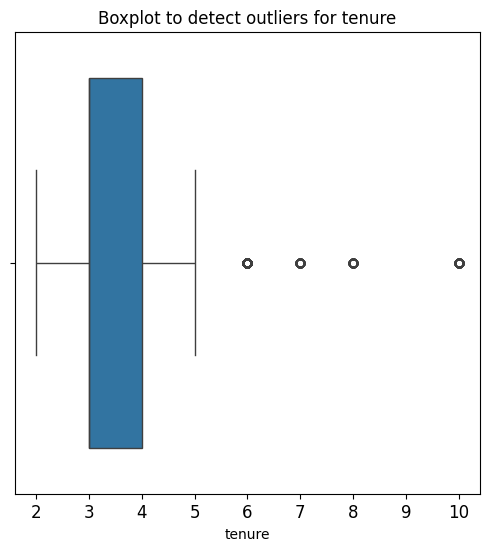

In [11]:
# Create a boxplot to visualize the distribution of `tenure` and detect any outliers
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['tenure'])
plt.show()

The above boxplot shows outliers in the tenure variable.

We are going to investigate how many rows in the data contain outliers in the tenure column.

In [12]:
# Determine the number of rows containing outliers 

# Compute the 25th percentile value in `tenure`
percentile25 = df['tenure'].quantile(0.25)

# Compute the 75th percentile value in `tenure`
percentile75 = df['tenure'].quantile(0.75)

# Compute the interquartile range in `tenure`
iqr = percentile75 - percentile25

# Define the upper limit and lower limit for non-outlier values in `tenure`
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in `tenure`
outliers = df[(df['tenure'] > upper_limit) | (df['tenure'] < lower_limit)]

# Count how many rows in the data contain outliers in `tenure`
print("Number of rows in the data containing outliers in `tenure`:", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in `tenure`: 824


In [13]:
# Get numbers of people who left vs. stayed

print(df['left'].value_counts())
print()

# Get percentages of people who left vs. stayed

print(df['left'].value_counts(normalize=True))

left
0    10000
1     1991
Name: count, dtype: int64

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


We examine variables that we are interested in, and create plots to visualize relationships between variables in the data.

We start by creating a stacked boxplot showing the average_monthly_hours distributions for number_project, comparing the distributions of employees who stayed versus those who left.

Box plots are very useful in visualizing distributions within data, but they can be deceiving without the context of how big the sample sizes that they represent are. So, you could also plot a stacked histogram to visualize the distribution of number_project for those who stayed and those who left.

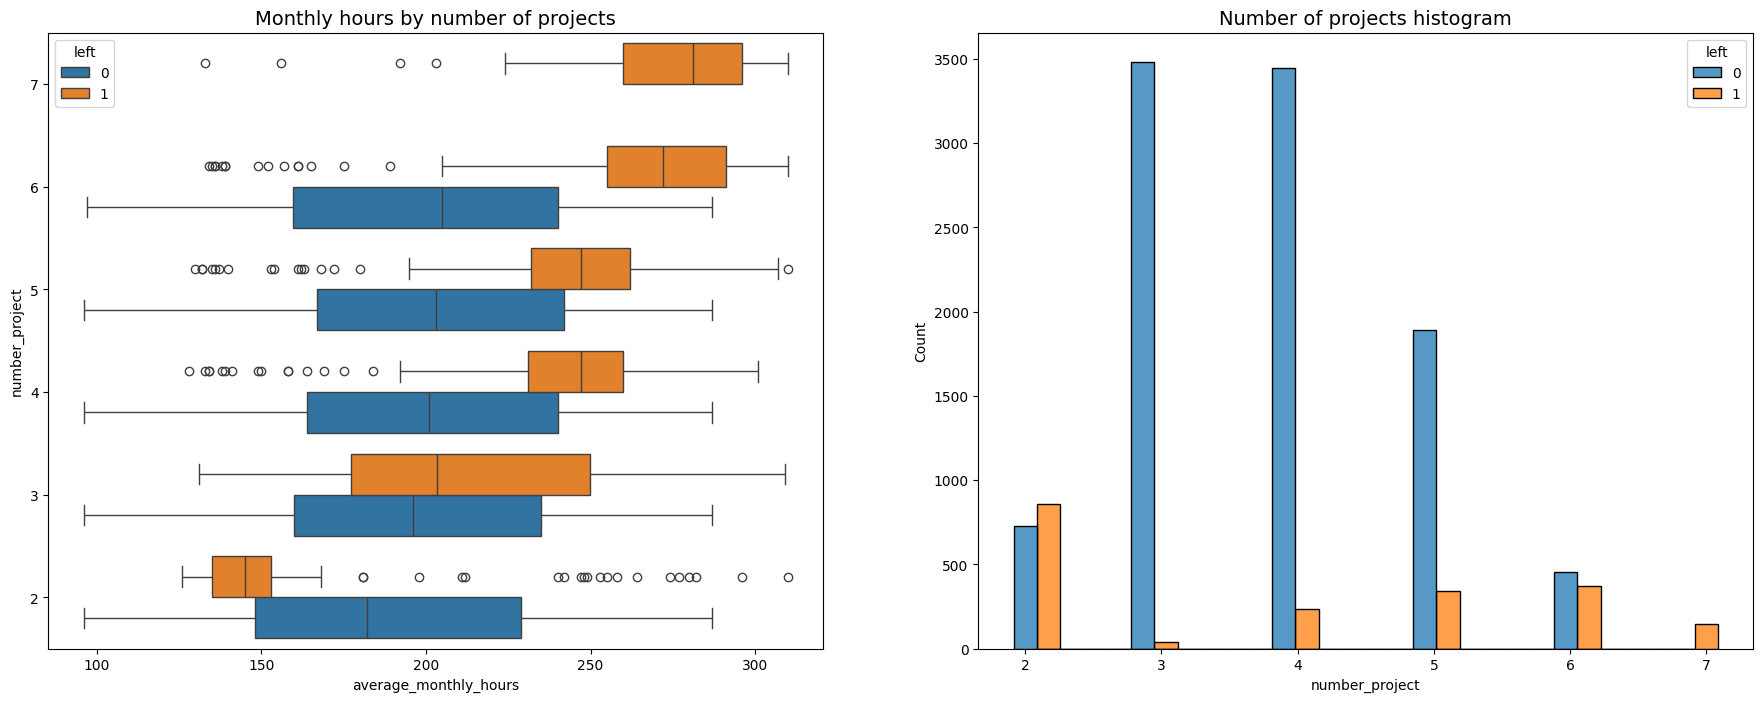

In [14]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing `average_monthly_hours` distributions for `number_project`, comparing employees who stayed versus those who left
sns.boxplot(data=df, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

# Create histogram showing distribution of `number_project`, comparing employees who stayed versus those who left
tenure_stay = df[df['left']==0]['number_project']
tenure_left = df[df['left']==1]['number_project']
sns.histplot(data=df, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

# Display the plots
plt.show()

It might be natural that people who work on more projects would also work longer hours. This appears to be the case here, with the mean hours of each group (stayed and left) increasing with the number of projects worked. However, a few things stand out from this plot.

There are two groups of employees who left the company: (A) those who worked considerably less than their peers with the same number of projects, and (B) those who worked much more. Of those in group A, it's possible that they were fired. It's also possible that this group includes employees who had already given their notice and were assigned fewer hours because they were already on their way out the door. For those in group B, it's reasonable to infer that they probably quit. The folks in group B likely contributed a lot to the projects they worked in; they might have been the largest contributors to their projects.

Everyone with seven projects left the company, and the interquartile ranges of this group and those who left with six projects was ~255–295 hours/month, much more than any other group.

The optimal number of projects for employees to work on seems to be 3–4. The ratio of left/stayed is very small for these cohorts.

If you assume a work week of 40 hours and two weeks of vacation per year, then the average number of working hours per month of employees working Monday–Friday = 50 weeks * 40 hours per week / 12 months = 166.67 hours per month. This means that, aside from the employees who worked on two projects, every group—even those who didn't leave the company—worked considerably more hours than this. It seems that employees here are overworked.

As the next step, we are going to confirm that all employees with seven projects left.

In [15]:
# Get value counts of stayed/left for employees with 7 projects
df[df['number_project']==7]['left'].value_counts()

left
1    145
Name: count, dtype: int64

This confirms that all employees with 7 projects have left.

Next, we are going to examine the average monthly hours versus the satisfaction levels.

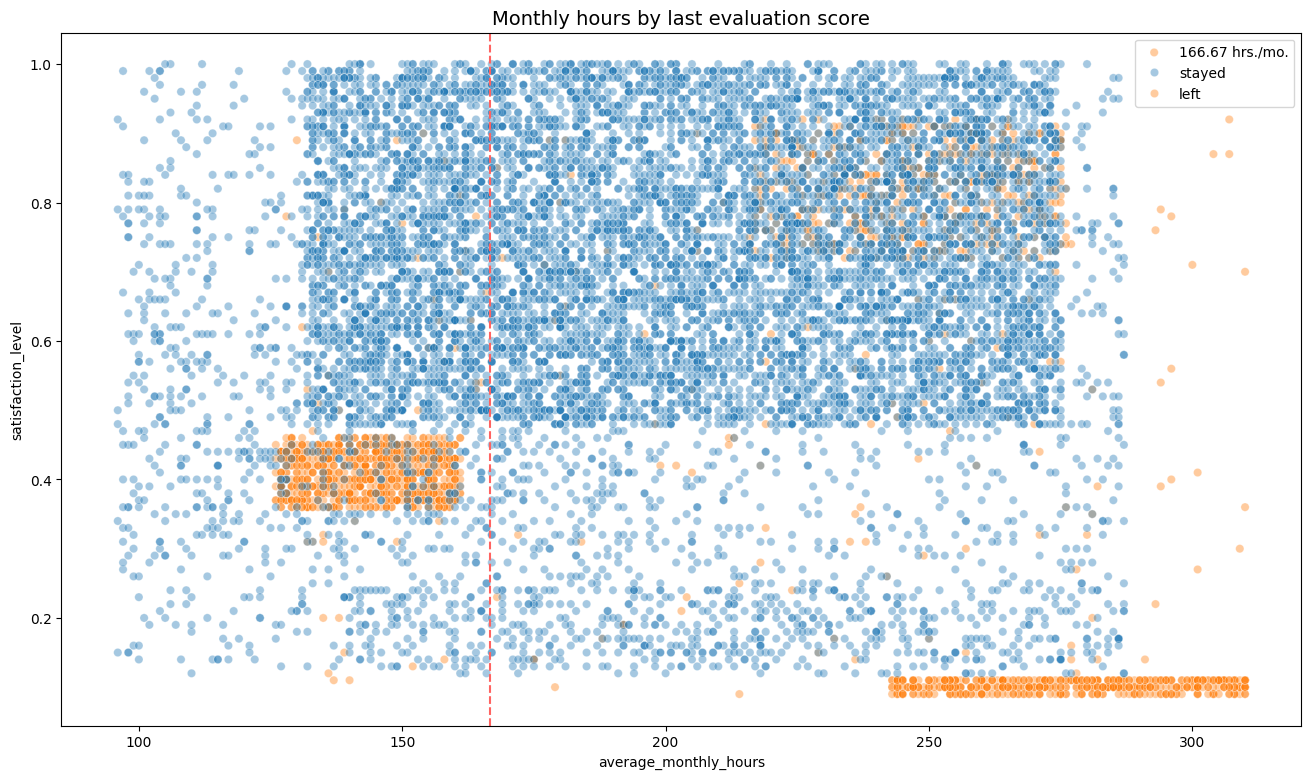

In [16]:
# Create scatterplot of `average_monthly_hours` versus `satisfaction_level`, comparing employees who stayed versus those who left
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'stayed', 'left'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

The scatterplot above shows that there was a sizeable group of employees who worked ~240–315 hours per month. 315 hours per month is over 75 hours per week for a whole year. It's likely this is related to their satisfaction levels being close to zero.

The plot also shows another group of people who left, those who had more normal working hours. Even so, their satisfaction was only around 0.4. It's difficult to speculate about why they might have left. It's possible they felt pressured to work more, considering so many of their peers worked more. And that pressure could have lowered their satisfaction levels.

Finally, there is a group who worked ~210–280 hours per month, and they had satisfaction levels ranging ~0.7–0.9.

Note the strange shape of the distributions here. This is indicative of data manipulation or synthetic data.

For the next visualization, it might be interesting to visualize satisfaction levels by tenure.

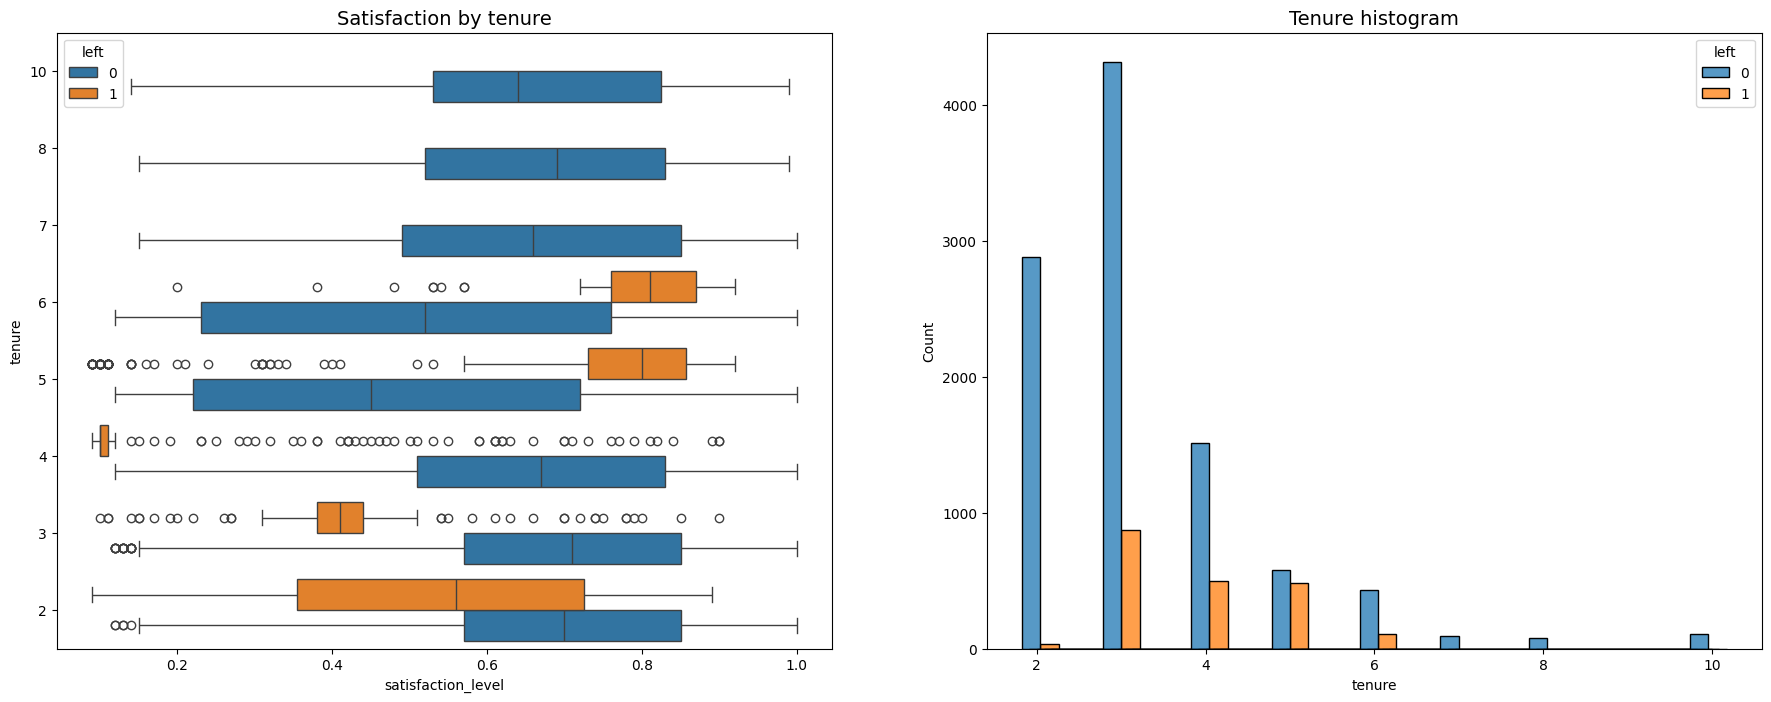

In [17]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing distributions of `satisfaction_level` by tenure, comparing employees who stayed versus those who left
sns.boxplot(data=df, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

# Create histogram showing distribution of `tenure`, comparing employees who stayed versus those who left
tenure_stay = df[df['left']==0]['tenure']
tenure_left = df[df['left']==1]['tenure']
sns.histplot(data=df, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show();

There are many observations we can make from this plot.

Employees who left fall into two general categories: dissatisfied employees with shorter tenures and very satisfied employees with medium-length tenures.
Four-year employees who left seem to have an unusually low satisfaction level. It's worth investigating changes to company policy that might have affected people specifically at the four-year mark, if possible.
The longest-tenured employees didn't leave. Their satisfaction levels aligned with those of newer employees who stayed.
The histogram shows that there are relatively few longer-tenured employees. It's possible that they're the higher-ranking, higher-paid employees.
As the next step in analyzing the data, you could calculate the mean and median satisfaction scores of employees who left and those who didn't.

In [18]:
# Calculate mean and median satisfaction scores of employees who left and those who stayed
df.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

mean  median
left                  
0     0.667365    0.69
1     0.440271    0.41

As expected, the mean and median satisfaction scores of employees who left are lower than those of employees who stayed. Interestingly, among employees who stayed, the mean satisfaction score appears to be slightly below the median score. This indicates that satisfaction levels among those who stayed might be skewed to the left.

Next, we proceed to examine salary levels for different tenures.

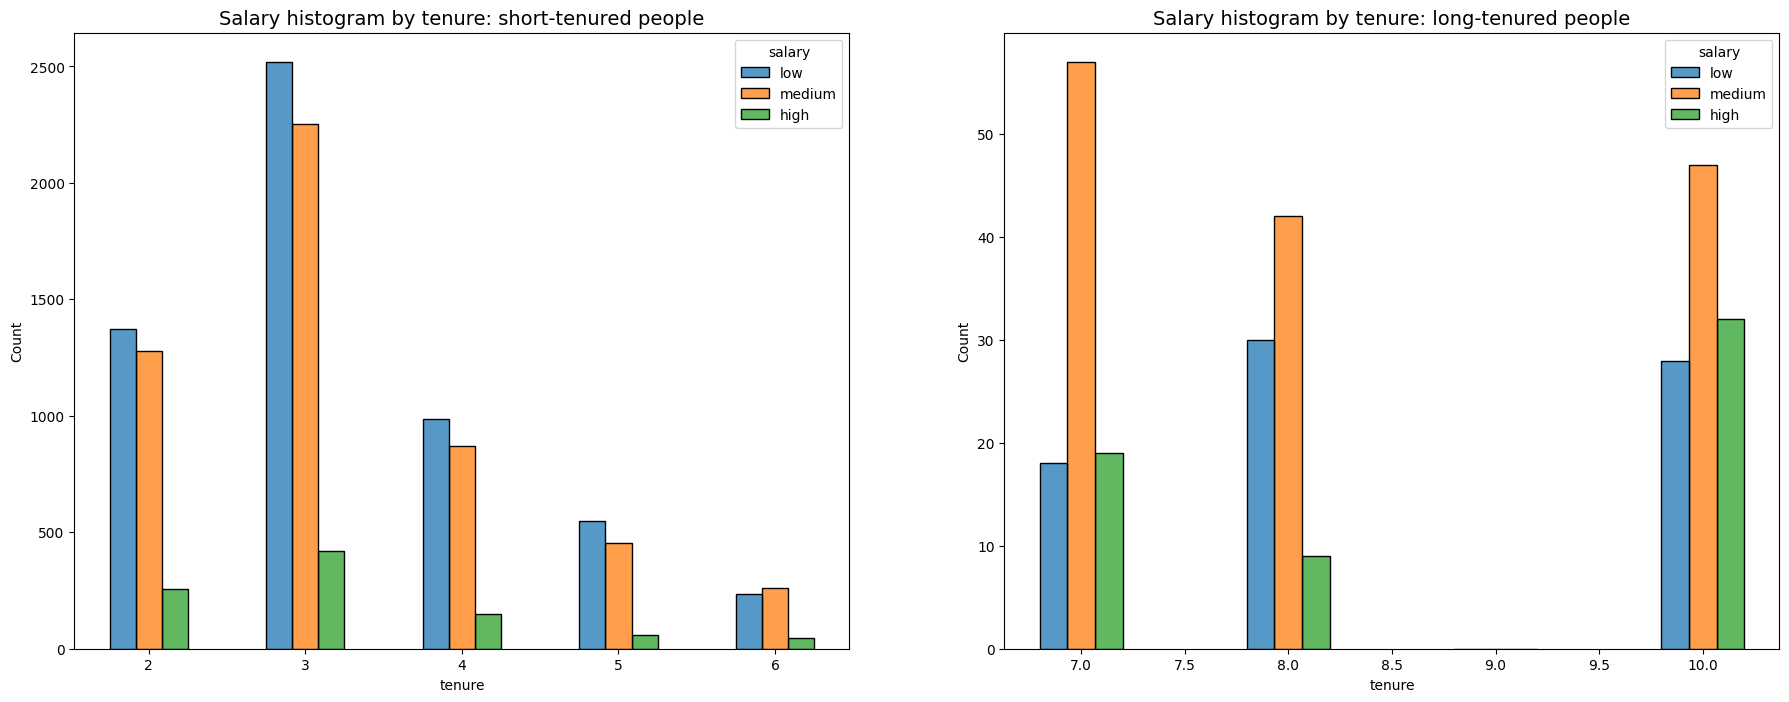

In [19]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Define short-tenured employees
tenure_short = df[df['tenure'] < 7]

# Define long-tenured employees
tenure_long = df[df['tenure'] > 6]

# Plot short-tenured histogram
sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

# Plot long-tenured histogram
sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14');

The plots above show that long-tenured employees were not disproportionately comprised of higher-paid employees.

Next, we will explore whether there's a correlation between working long hours and receiving high evaluation scores. We are going to create a scatterplot of average_monthly_hours versus last_evaluation.

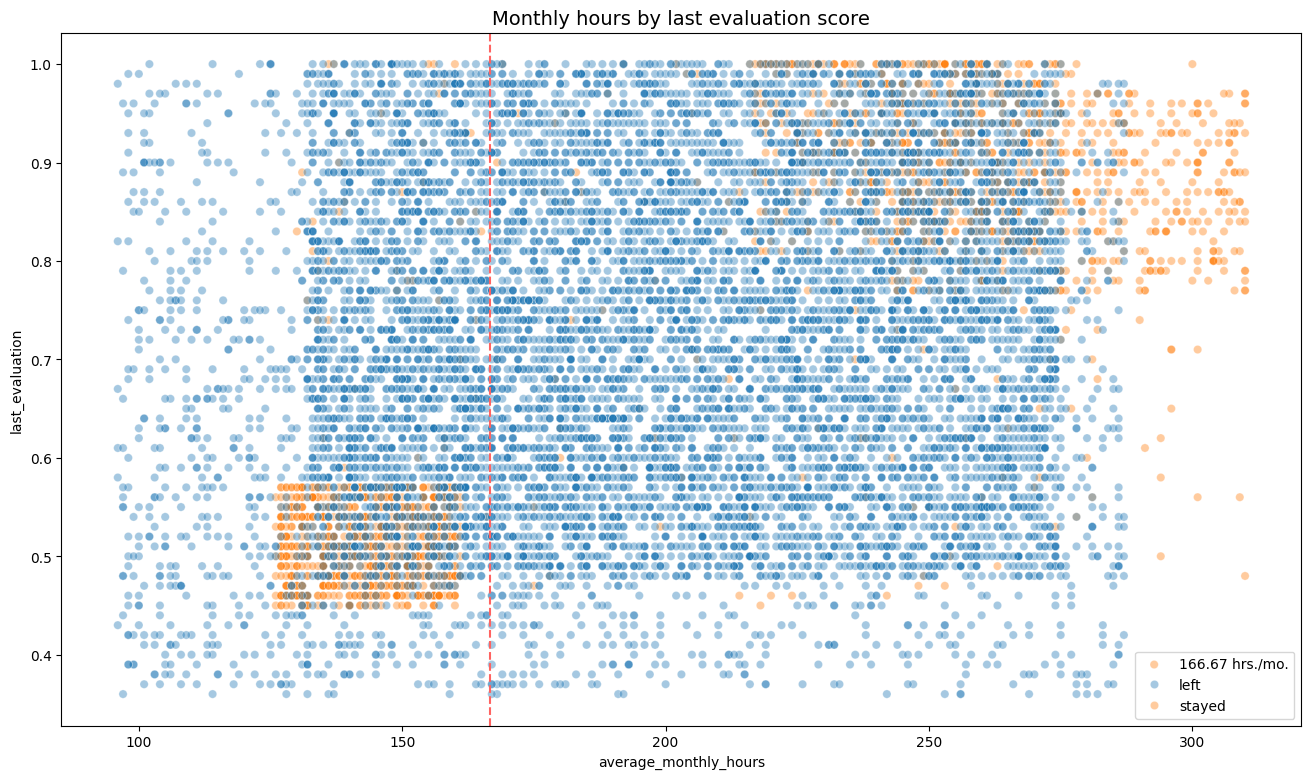

In [20]:
# Create scatterplot of `average_monthly_hours` versus `last_evaluation`
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

The following observations can be made from the scatterplot above:

The scatterplot indicates two groups of employees who left: overworked employees who performed very well and employees who worked slightly under the nominal monthly average of 166.67 hours with lower evaluation scores.
There seems to be a correlation between hours worked and evaluation score.
There isn't a high percentage of employees in the upper left quadrant of this plot; but working long hours doesn't guarantee a good evaluation score.
Most of the employees in this company work well over 167 hours per month.
Next, we are going to examine whether employees who worked very long hours were promoted in the last five years.

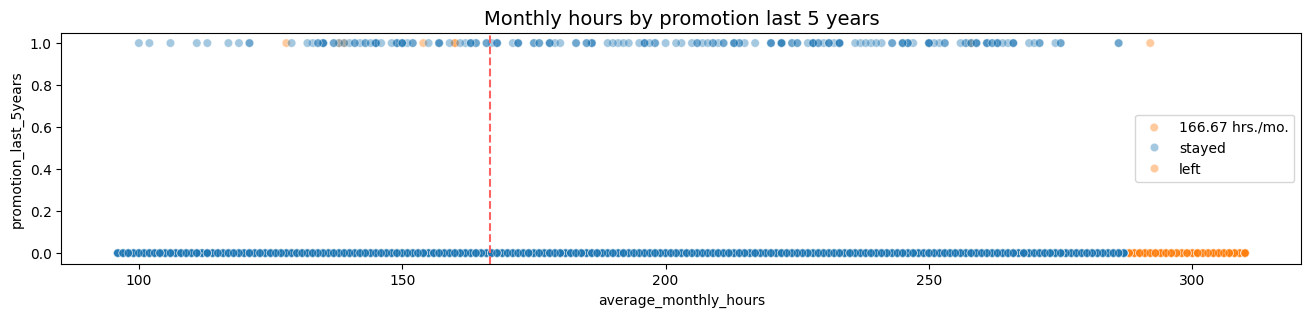

In [21]:
# Create plot to examine the relationship between `average_monthly_hours` and `promotion_last_5years`
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'stayed', 'left'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

The plot above shows the following:

very few employees who were promoted in the last five years left

very few employees who worked the most hours were promoted

all of the employees who left were working the longest hours

Next, we inspect how the employees who left are distributed across departments.

In [22]:
# Display counts for each department
df["department"].value_counts()

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

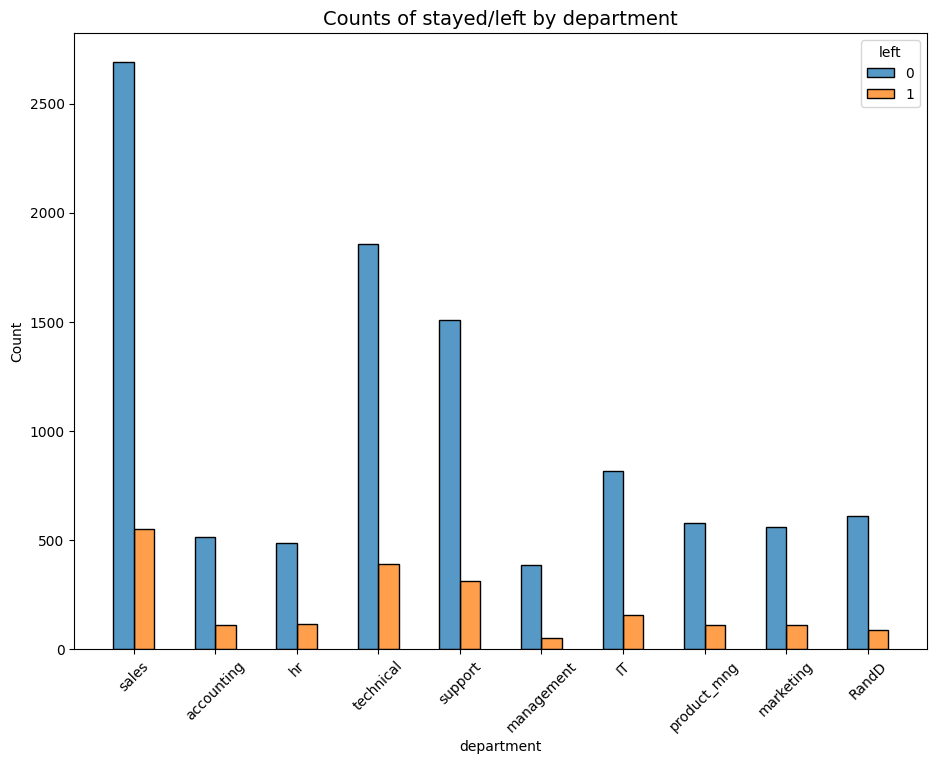

In [23]:
# Create stacked histogram to compare department distribution of employees who left to that of employees who didn't
plt.figure(figsize=(11,8))
sns.histplot(data=df, x='department', hue='left', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of stayed/left by department', fontsize=14);

Across all the departments, there is no significant difference in the proportion of employees who left to those who stayed.

Lastly, you could check for strong correlations between variables in the data.

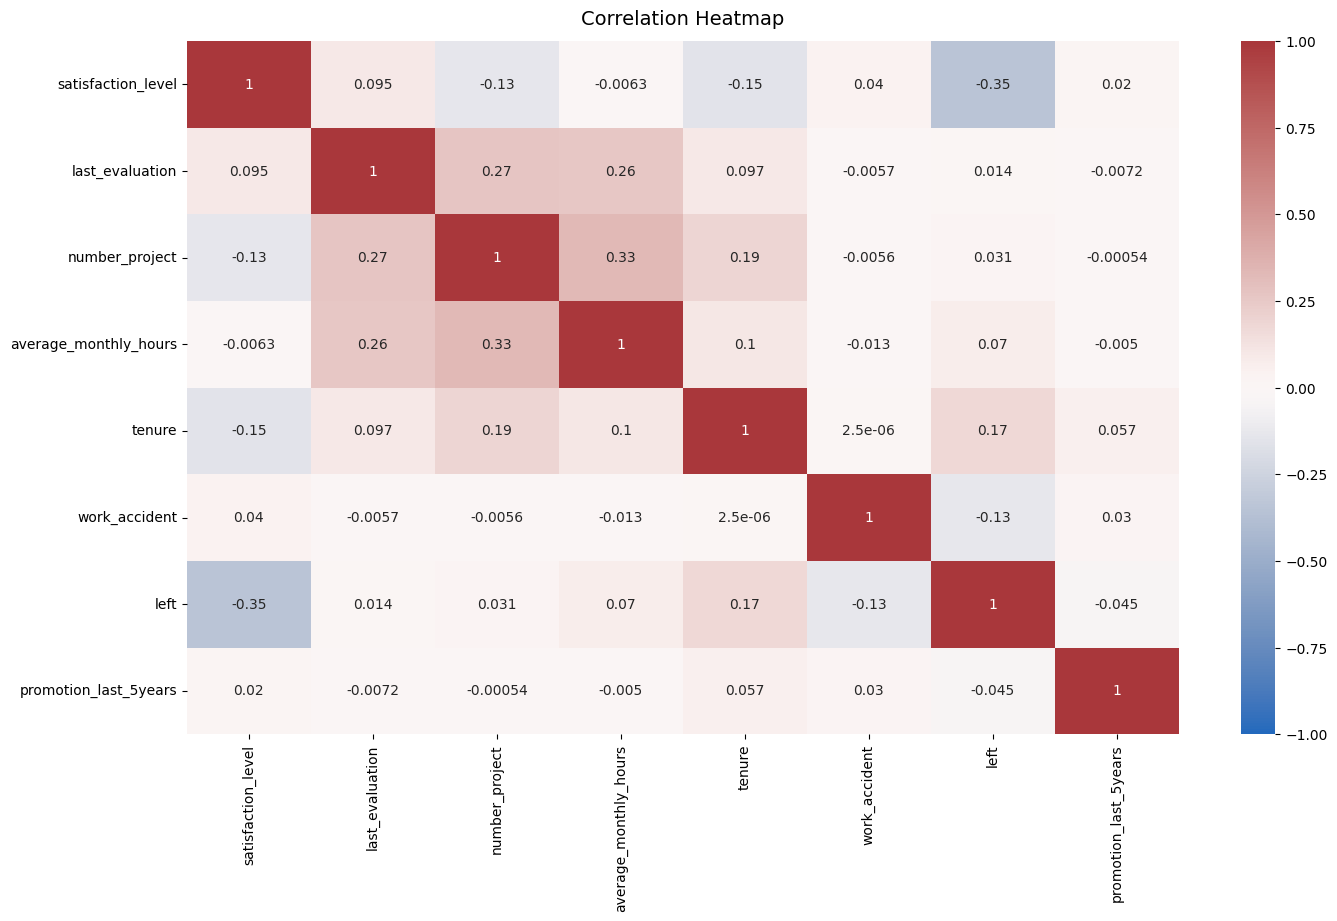

In [24]:
# Plot a correlation heatmap
plt.figure(figsize=(16, 9))

#Remove non-numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

heatmap = sns.heatmap(numeric_df.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

The correlation heatmap confirms that the number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their satisfaction level.

It appears that employees are leaving the company as a result of poor management. Leaving is tied to longer working hours, too many projects, and generally lower satisfaction levels.

It can be ungratifying to work long hours and not receive promotions or good evaluation scores. There's a sizeable group of employees at this company who are probably burned out. It also appears that if an employee has spent more than six years at the company, they tend not to leave.

Next, we will: 

Determine which models are most appropriate

Construct the model

Confirm model assumptions

Evaluate model results to determine how well your model fits the data

## Logistic regression
Note that binomial logistic regression suits the task because it involves binary classification.

Before splitting the data, encode the non-numeric variables. There are two: department and salary.

department is a categorical variable, which means you can dummy it for modeling.

salary is categorical too, but it's ordinal. There's a hierarchy to the categories, so it's better not to dummy this column, but rather to convert the levels to numbers, 0–2.

In [25]:
# Copy the dataframe
df_enc = df.copy()

# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

# Dummy encode the `department` column
df_enc = pd.get_dummies(df_enc, drop_first=False)

# Display the new dataframe
df_enc.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0          False   
1       6              0     1                      0       1          False   
2       4              0     1                      0       1          False   
3       5              0     1                      0       0          False   
4       3              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
1             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False

We will create a heatmap to visualize how correlated variables are. Considering the variables we're interested in examining correlations between.

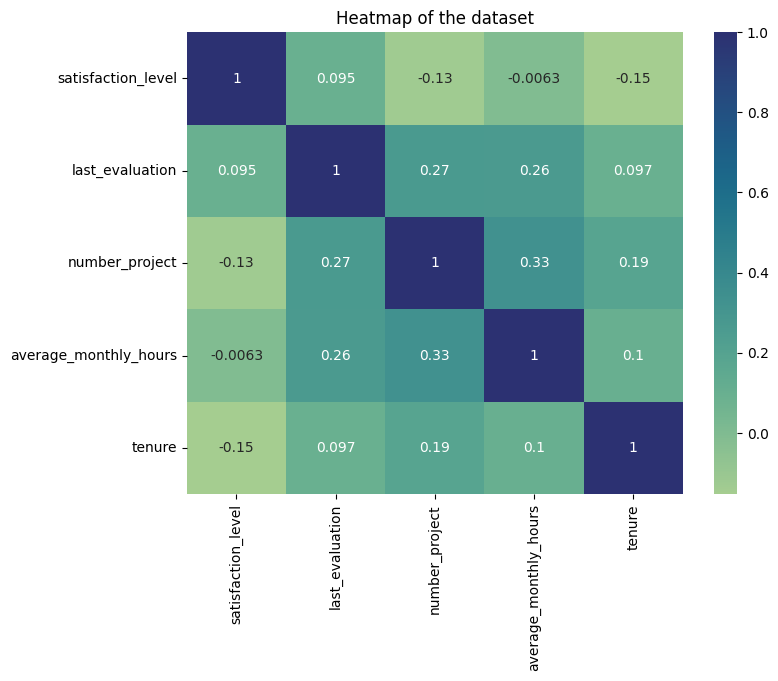

In [26]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

We will proceed to create a stacked bar chart to visualize the number of employees across departments, comparing those who left with those who didn't.

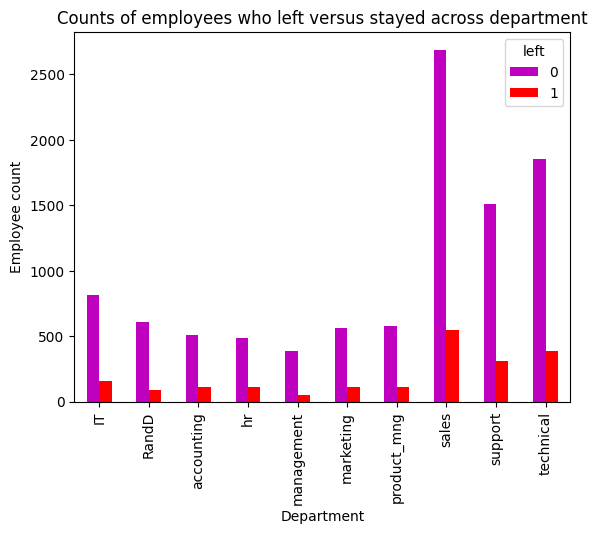

In [27]:
# Create a stacked bart plot to visualize number of employees across department, comparing those who left with those who didn't
# In the legend, 0 (purple color) represents employees who did not leave, 1 (red color) represents employees who left
pd.crosstab(df['department'], df['left']).plot(kind ='bar',color='mr')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

Logistic regression is quite sensitive to outliers; it would be a good idea at this stage to remove the outliers in the tenure column that were identified earlier.

In [28]:
# Select rows without outliers in `tenure` and save resulting dataframe in a new variable
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]

# Display first few rows of new dataframe
df_logreg.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   
5                0.41             0.50               2                    153   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0          False   
2       4              0     1                      0       1          False   
3       5              0     1                      0       0          False   
4       3              0     1                      0       0          False   
5       3              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   
5             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   
5                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False  
5              True               False                 False

We isolate the outcome variable, which is the variable we want our model to predict

In [29]:
# Isolate the outcome variable
y = df_logreg['left']

# Display first few rows of the outcome variable
y.head() 

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

We proceed to select the features that we want to use in our model

The feature that will help us in achieving this is "left"

In [30]:
# Select the features you want to use in your model
X = df_logreg.drop('left', axis=1)

# Display the first few rows of the selected features 
X.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   
5                0.41             0.50               2                    153   

   tenure  work_accident  promotion_last_5years  salary  department_IT  \
0       3              0                      0       0          False   
2       4              0                      0       1          False   
3       5              0                      0       0          False   
4       3              0                      0       0          False   
5       3              0                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   
5             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   
5                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False  
5              True               False                 False

We are going to split the data into training set and testing set respectively. We won't forget to stratify based on the values in y, since the classes are unbalanced

In [31]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

We construct a logistic regression model using the train dataset and fit into the test data

In [32]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

We test the logistic regression model. We are going to use this model to make predictions on the test data

In [33]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

We are going to create a confusion matrix to visualize the results of the logistic regression model.

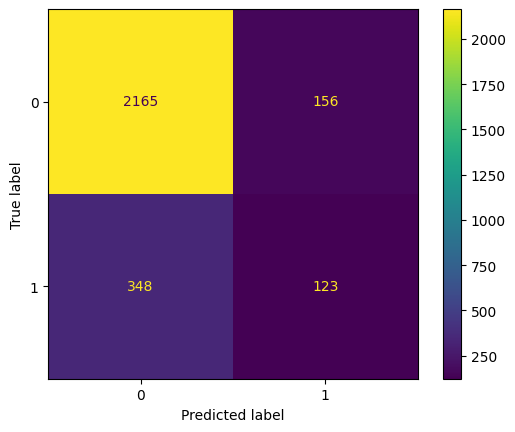

In [34]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

The upper-left quadrant displays the number of true negatives. The upper-right quadrant displays the number of false positives. The bottom-left quadrant displays the number of false negatives. The bottom-right quadrant displays the number of true positives.

True negatives: The number of people who did not leave that the model accurately predicted did not leave.

False positives: The number of people who did not leave the model inaccurately predicted as leaving.

False negatives: The number of people who left that the model inaccurately predicted did not leave

True positives: The number of people who left the model accurately predicted as leaving

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

We will create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the logistic regression model.

we also will check the class balance in the data. In other words, check the value counts in the left column. Since this is a binary classification task, the class balance informs the way you interpret accuracy metrics.

In [35]:
df_logreg['left'].value_counts(normalize=True)

left
0    0.831468
1    0.168532
Name: proportion, dtype: float64

There is an approximately 83%-17% split. So the data is not perfectly balanced, but it is not too imbalanced. If it was more severely imbalanced, we might want to resample the data to make it more balanced. In this case, we can use this data without modifying the class balance and continue evaluating the model.

In [36]:
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.44      0.26      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792



The classification report above shows that the logistic regression model achieved a precision of 79%, recall of 82%, f1-score of 80% (all weighted averages), and accuracy of 82%. However, if it's most important to predict employees who leave, then the scores are significantly lower.

WE MOVE TO THE DECISION TREE MODEL

This approach covers implementation of Decision Tree and Random Forest.

Isolate the outcome variable.

In [37]:
# Isolate the outcome variable
y = df_enc['left']

# Display the first few rows of `y`
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

We proceed to select the features

In [38]:
# Select the features
X = df_enc.drop('left', axis=1)

# Display the first few rows of `X`
X.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  promotion_last_5years  salary  department_IT  \
0       3              0                      0       0          False   
1       6              0                      0       1          False   
2       4              0                      0       1          False   
3       5              0                      0       0          False   
4       3              0                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
1             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False

We will split the data into training, validating and testing set

In [39]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

We construct a decision tree model and set up cross-validated grid-search to exhaustively search for the best model parameters

We will also fit the model to the training set to the model

In [40]:
# Corrected code
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Fix: Use a list instead of a set for scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

# Now this should work
tree1.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [41]:
# Check best parameters
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

We identify the best AUC score achieved by the decision tree model on the training set

In [42]:
# Check best AUC score on CV
tree1.best_score_

np.float64(0.969819392792457)

This is a very strong AUC score, which shows that this model can predict employees who will leave very well.

Next, we will write a function that will help us extract all the scores from the grid search.

In [43]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table


In [44]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819

All of these scores from the decision tree model are strong indicators of good model performance.

Recall that decision trees can be vulnerable to overfitting, and random forests avoid overfitting by incorporating multiple trees to make predictions. We will proceed to construct a random forest model next.

RANDOM FOREST ROUND 1

Construct a random forest model and set up a cross-validated grid-search to exhuastively search for the best model parameters.

In [45]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {
    "max_depth": [5, None],
    "max_samples": [0.7, 1.0],
    "min_samples_leaf": [1, 2],
    "min_samples_split": [2, 4],
    "n_estimators": [300],
    "max_features": ["sqrt"]  # usually better than 1.0
}

# Assign a dictionary of scoring metrics to capture
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

We fit the model to the training set

In [46]:
%%time
rf1.fit(X_train, y_train) # --> Wall time: ~10min

CPU times: user 1min 38s, sys: 181 ms, total: 1min 38s
Wall time: 1min 38s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, None], 'max_features': ['sqrt'],
                         'max_samples': [0.7, 1.0], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4], 'n_estimators': [300]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

We are going to save our model 

We will specify the path to where we want to save our model

In [47]:
# Define a path to the folder where you want to save the model
path = '/kaggle/working/Salifort_Motors'

We are going to save our model

We use Pickle; we are going to define functions to pickle the model and read in the model.

In [48]:
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [49]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [50]:
# Write pickle
write_pickle(path, rf1, 'hr_rf1')

In [51]:
# Read pickle
rf1 = read_pickle(path, 'hr_rf1')

We identify the best AUC score achieved by the random forest model on the training set.

In [52]:
# Check best AUC score on CV
rf1.best_score_

np.float64(0.9798774712907342)

We identify the optimal values for the parameters of the random forest model.

In [53]:
# Check best params
rf1.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

We collect the evaluation scores on the training set for the decision tree and the random forest models

In [54]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.984047  0.908245  0.944609   0.98232  0.979877


The evaluation scores of the random forest model are better than those of the decision tree model, with the exception of recall (the recall score of the random forest model is approximately 0.001 lower, which is a negligible amount). This indicates that the random forest model mostly outperforms the decision tree model.

Next, you can evaluate the final model on the test set.

Define a function that gets all the scores from a model's predictions.

In [55]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

We will use the best-performing model to predict on the test set

In [56]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

model  precision    recall        f1  accuracy       AUC
0  random forest1 test   0.989083  0.909639  0.947699  0.983322  0.953819

The test scores are very similar to the validation scores, which is good. This appears to be a strong model. Since this test set was only used for this model, we are more confident that our model's performance on this data is representative of how it will perform on new, unseen data.

FEATURE ENGINEERING

We might be skeptical of the high evaluation scores. There is a chance that there is some data leakage occurring. Data leakage is when you use data to train your model that should not be used during training, either because it appears in the test data or because it's not data that you'd expect to have when the model is actually deployed. Training a model with leaked data can give an unrealistic score that is not replicated in production.
In this case, it's likely that the company won't have satisfaction levels reported for all of its employees. It's also possible that the `average_monthly_hours` column is a source of some data leakage. If employees have already decided to quit or have already been identified by management as people to be fired, they may be working fewer hours.
The first round of decision tree and random forest models included all variables as features. This next round will incorporate feature engineering to build improved models.
We could proceed by dropping `satisfaction_level` and creating a new feature that roughly captures whether an employee is overworked. We could call this new feature `overworked`. It will be a binary variable.

In [57]:
# Drop `satisfaction_level` and save resulting dataframe in new variable
df1 = df_enc.drop('satisfaction_level', axis=1)

# Display first few rows of new dataframe
df1.head()

last_evaluation  number_project  average_monthly_hours  tenure  \
0             0.53               2                    157       3   
1             0.86               5                    262       6   
2             0.88               7                    272       4   
3             0.87               5                    223       5   
4             0.52               2                    159       3   

   work_accident  left  promotion_last_5years  salary  department_IT  \
0              0     1                      0       0          False   
1              0     1                      0       1          False   
2              0     1                      0       1          False   
3              0     1                      0       0          False   
4              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
1             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False

In [58]:
# Create `overworked` column. For now, it's identical to average monthly hours.
df1['overworked'] = df1['average_monthly_hours']

# Inspect max and min average monthly hours values
print('Max hours:', df1['overworked'].max())
print('Min hours:', df1['overworked'].min())

Max hours: 310
Min hours: 96


166.67 is approximately the average number of monthly hours for someone who works 50 weeks per year, 5 days per week, 8 hours per day.

We define being overworked as working more than 175 hours per month on average.

To make the overworked column binary, we could reassign the column using a boolean mask.

df3['overworked'] > 175 creates a series of booleans, consisting of True for every value > 175 and False for every value ≤ 175
.astype(int) converts all True to 1 and all False to 0

In [59]:
# Define `overworked` as working > 175 hrs/week
df1['overworked'] = (df1['overworked'] > 175).astype(int)

# Display first few rows of new column
df1['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

We drop the average monthly hours column

In [60]:
# Drop the `average_monthly_hours` column
df1 = df1.drop('average_monthly_hours', axis=1)

# Display first few rows of resulting dataframe
df1.head()

last_evaluation  number_project  tenure  work_accident  left  \
0             0.53               2       3              0     1   
1             0.86               5       6              0     1   
2             0.88               7       4              0     1   
3             0.87               5       5              0     1   
4             0.52               2       3              0     1   

   promotion_last_5years  salary  department_IT  department_RandD  \
0                      0       0          False             False   
1                      0       1          False             False   
2                      0       1          False             False   
3                      0       0          False             False   
4                      0       0          False             False   

   department_accounting  department_hr  department_management  \
0                  False          False                  False   
1                  False          False                  False   
2                  False          False                  False   
3                  False          False                  False   
4                  False          False                  False   

   department_marketing  department_product_mng  department_sales  \
0                 False                   False              True   
1                 False                   False              True   
2                 False                   False              True   
3                 False                   False              True   
4                 False                   False              True   

   department_support  department_technical  overworked  
0               False                 False           0  
1               False                 False           1  
2               False                 False           1  
3               False                 False           1  
4               False                 False           0

We again isolate the features and target variables

In [61]:
# Isolate the outcome variable
y = df1['left']

# Select the features
X = df1.drop('left', axis=1)

We split the data into training and testing sets

In [62]:
# Create test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

DECISION TREE ROUND 2 

In [63]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {
    "max_depth": [4, 6, 8, None],
    "min_samples_leaf": [1, 2, 5],
    "min_samples_split": [2, 4, 6]
}
# Assign a dictionary of scoring metrics to capture
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}
# Instantiate GridSearch
tree2 = GridSearchCV(
    tree,
    cv_params,
    scoring=scoring,
    cv=4,
    refit="roc_auc",
    n_jobs=-1,
    verbose=1
)
tree2.fit(X_train, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [64]:
# Check best params
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [65]:
# Check best AUC score on CV
tree2.best_score_

np.float64(0.9586752505340426)

This model performs very well, even without satisfaction levels and detailed hours worked data.

Next, check the other scores.

In [66]:
# Get all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675


Some of the other scores fell. That's to be expected given fewer features were taken into account in this round of the model. Still, the scores are very good.

RANDOM FOREST - ROUND 2

In [67]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {
    "max_depth": [3, 5, None],
    "max_features": ["sqrt"],        # usually better than 1.0 for RF
    "max_samples": [0.7, 1.0],
    "min_samples_leaf": [1, 2, 3],
    "min_samples_split": [2, 3, 4],
    "n_estimators": [300, 500],
}

# Assign a dictionary of scoring metrics to capture (MUST be dict, not set)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}

# Instantiate GridSearch
rf2 = GridSearchCV(
    rf,
    cv_params,
    scoring=scoring,
    cv=4,
    refit="roc_auc",
    n_jobs=-1,     # speeds up training
    verbose=1
)
# Fit the model
rf2.fit(X_train, y_train)

Fitting 4 folds for each of 108 candidates, totalling 432 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [3, 5, None], 'max_features': ['sqrt'],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [68]:
# Write pickle
write_pickle(path, rf2, 'hr_rf2')

In [69]:
# Read in pickle
rf2 = read_pickle(path, 'hr_rf2')

In [70]:
# Check best params
rf2.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 300}

In [71]:
# Check best AUC score on CV
rf2.best_score_

np.float64(0.96873476079196)

In [72]:
# Get all CV scores
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675
               model  precision    recall        F1  accuracy       auc
0  random forest2 cv   0.911854  0.866715  0.888685  0.963972  0.968735


Again, the scores dropped slightly, but the random forest performs better than the decision tree if using AUC as the deciding metric.

We proceed to score the champion model on the test set now.

In [73]:
# Get predictions on test data
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

model  precision    recall        f1  accuracy       AUC
0  random forest2 test   0.904564  0.875502  0.889796  0.963976  0.928551

This seems to be a stable, well-performing final model.

Plot a confusion matrix to visualize how well it predicts on the test set.

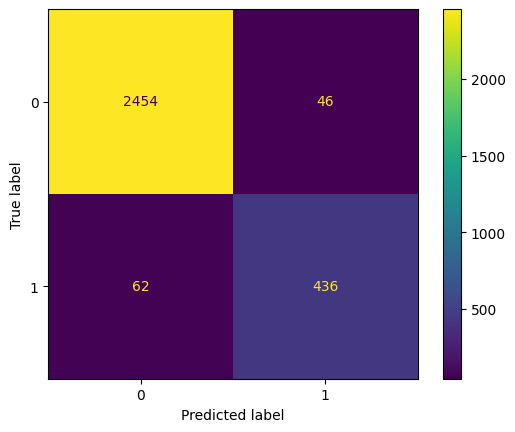

In [74]:
# Generate array of values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');

DECISION TREE SPLITS

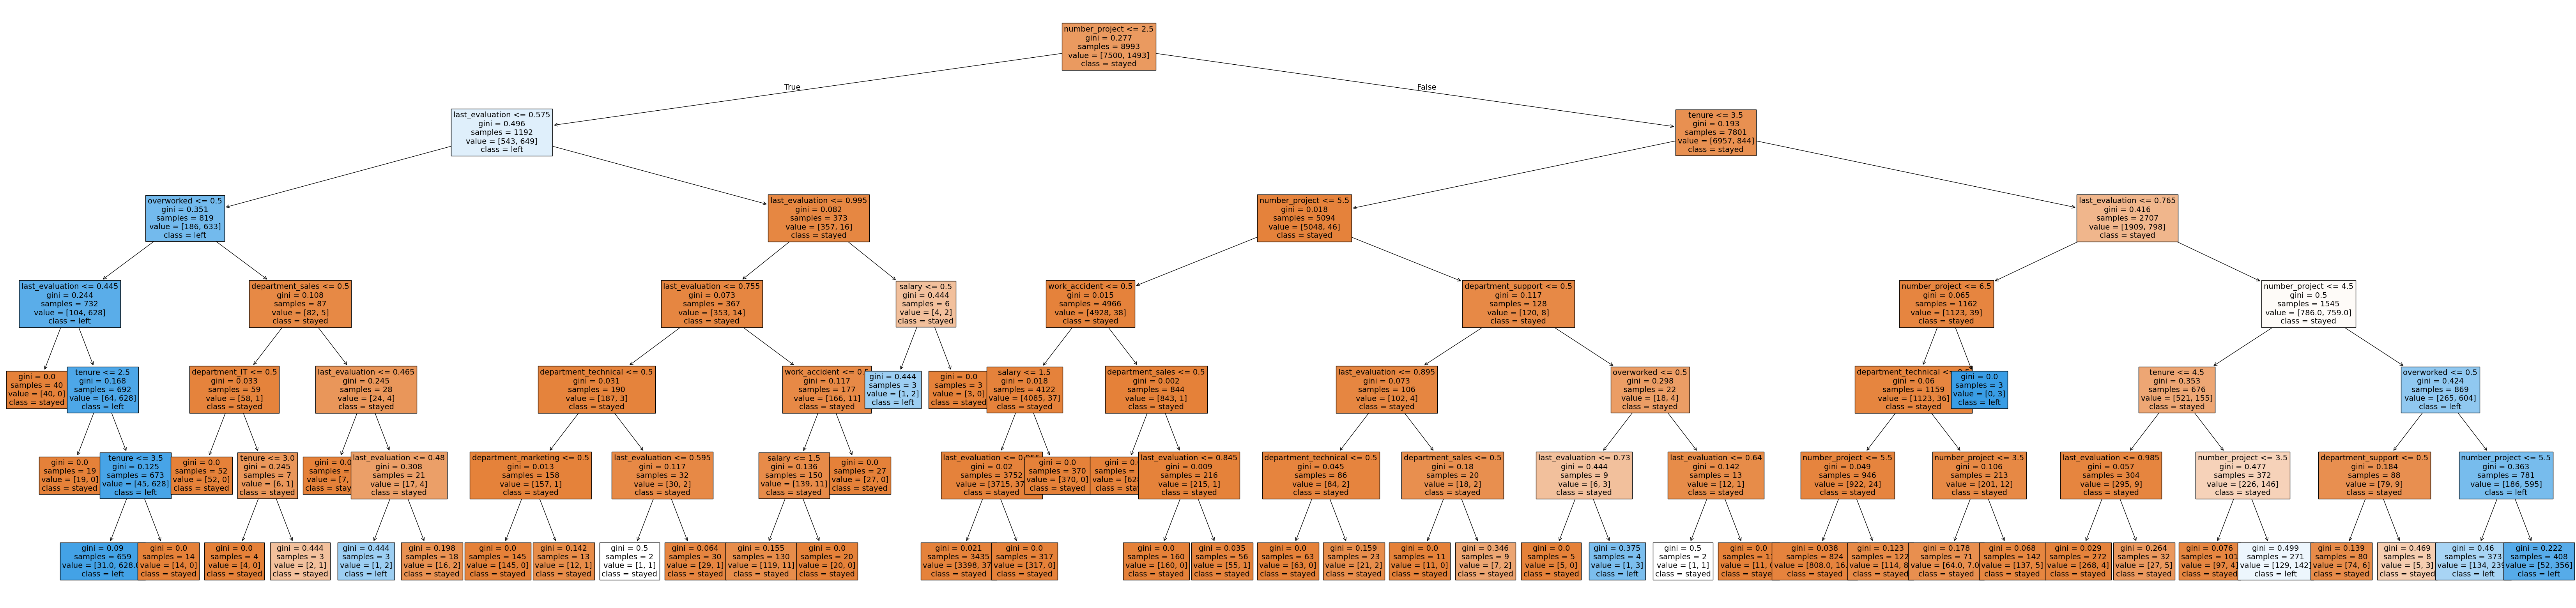

In [75]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

DECISION TREE FEATURE IMPORTANCE

In [76]:
#tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns=X.columns)
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

gini_importance
last_evaluation              0.343958
number_project               0.343385
tenure                       0.215681
overworked                   0.093498
department_support           0.001142
salary                       0.000910
department_sales             0.000607
department_technical         0.000418
work_accident                0.000183
department_IT                0.000139
department_marketing         0.000078

We then create a barplot to visualize the decision tree feature importances.

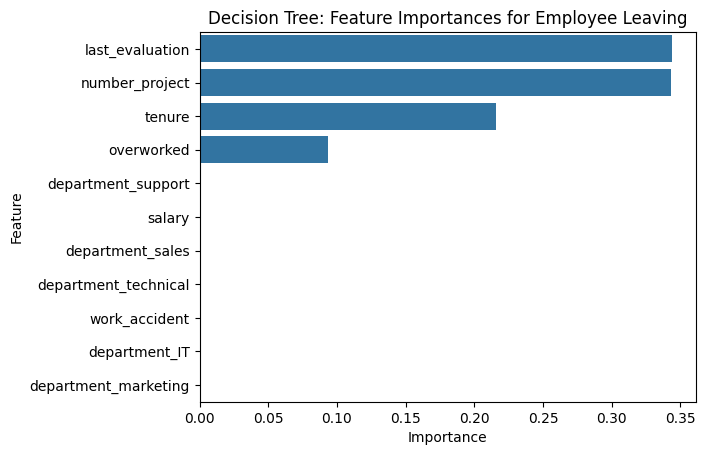

In [77]:
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

The barplot above shows that in this decision tree model, last_evaluation, number_project, tenure, and overworked have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, left.

RANDOM FOREST FEATURE IMPORTANCE

We plot the feature importance for the random forest model

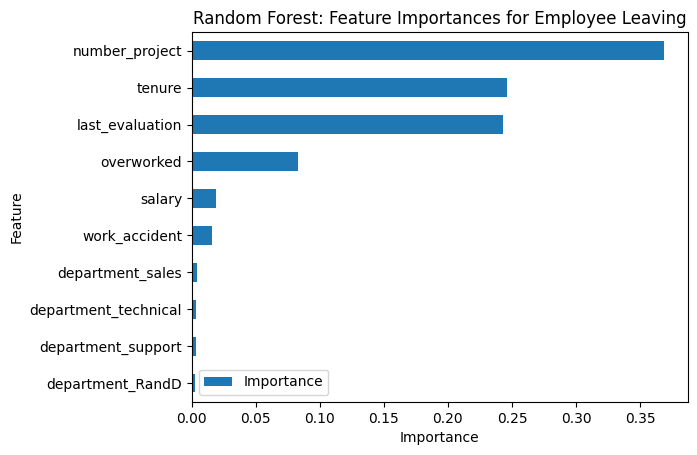

In [78]:
# Get feature importances
feat_impt = rf2.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

The plot above shows that in this random forest model, last_evaluation, number_project, tenure, and overworked have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, left, and they are the same as the ones used by the decision tree model.

## CONCLUSIONS AND RECOMMENDATION
The models and the feature importances extracted from the models confirm that employees at the company are overworked.
To retain employees, the following recommendations could be presented to the stakeholders:

Cap the number of projects employees can work on.

Consider promoting employees who have been with the company for atleast four years, or conduct further investigation about why four-year tenured employees are so dissatisfied.

If employees aren't familiar with the company's overtime pay policies, inform them about this. If the expectations around workload and time off aren't explicit, make them clear.

Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts.

High evaluation scores should not be reserved for employees who work 200+ hours per month.

Consider a proportionate scale for rewarding employees who contribute more/put in more effort.


## NEXT STEPS
It may be justified to still have some concern about data leakage. It could be prudent to consider how predictions change when `last_evaluation` is removed from the data. It's possible that evaluations aren't performed very frequently, in which case it would be useful to be able to predict employee retention without this feature. It's also possible that the evaluation score determines whether an employee leaves or stays, in which case it could be useful to pivot and try to predict performance score. The same could be said for satisfaction score.

For another project, consider building a K-means model on this data and analyzing the clusters. This approach may reveal valuable insights.